### Description
This is skeleton code for **Exercise 2: Regression** for *L335 Machine Visual Perception*. For this task, we will take advantage of Implicit Neural Representations (INR), an alternative way to represent signals such as images, videos and 3D volumes. This exercise is limited to RGB images to accommodate easy experimenting.

The basic idea is simple. We aim to learn a mapping $f$ between spatial coordinates ($x, y$ for a 2D image) and the corresponding RGB pixel values:
$$ (r, g, b) = f(x, y) = f(\mathbf g),$$

where $\mathbf g$ is a 2D grid coordinate. Note how this is different to directly storing all RGB values in a spatial grid. We will approximate $f$ with a neural network and fit it for an example image. For an image with height $h$ and width $w$, we have $h \times w$ training samples for our supervised regression problem.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

First, run the rest of this file without any changes as a sanity check.

In [18]:
import torch, torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import trange
import gdown
import dill
import numpy as np
import itertools

# !pip install torchmetrics
import torchmetrics

Read the example image and normalise pixel values to the range [0, 1]. Also set up the coordinate input to the network.

In [2]:
# !gdown https://drive.google.com/uc?id=1KQCp48jXxlioyL6eYf9pfD-BkZyHvg5s
gdown.download('https://drive.google.com/uc?id=1KQCp48jXxlioyL6eYf9pfD-BkZyHvg5s', quiet=False)

filename = 'kings_chapel.jpg'
img = torchvision.io.read_image(filename) / 255
_, h, w = img.shape
img = img.permute(1,2,0).reshape(-1, 3)

tensors = (torch.linspace(-1, 1, steps=h), torch.linspace(-1, 1, steps=w))
coord_grid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1).reshape(-1, 2)

Downloading...
From: https://drive.google.com/uc?id=1KQCp48jXxlioyL6eYf9pfD-BkZyHvg5s
To: /tmp/pycharm_project_954/kings_chapel.jpg
100%|██████████| 271k/271k [00:00<00:00, 8.16MB/s]


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # Update this line if you want to use a different device such as TPU or Macbook's MPS
print(f'Using {device} device')
if device == 'cuda':
    print(torch.cuda.get_device_name())

Using cuda device
Tesla P100-PCIE-16GB


Start with a simple MLP. It should have 2 inputs (corresponding to spatial locations $x, y$) and 3 outputs. We will use 3 hidden layers with 256 neurons each.

In [4]:
class IRN(nn.Module):
    def __init__(self, positional_encoding=False, n_hidden=256, mapping_size=256, std=10):
        super(IRN, self).__init__()
        self.mapping_size = mapping_size
        self.positional_encoding = positional_encoding
        self.n_in = 2
        self.n_out = 3

        if self.positional_encoding:
            self.B = torch.normal(0, std, (self.n_in, self.mapping_size)).to(device)

        self.layer_in = nn.Linear(2*self.mapping_size if positional_encoding else self.n_in, n_hidden)
        self.layer_hidden = nn.Linear(n_hidden, n_hidden)
        self.layer_out = nn.Linear(n_hidden, self.n_out)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if self.positional_encoding:
            x = self.positional_encoding_function(x)
        x = self.relu(self.layer_in(x))
        x = self.relu(self.layer_hidden(x))
        x = self.sigmoid(self.layer_out(x))
        return x

    def positional_encoding_function(self, x):
        x_proj = 2 * torch.pi * x @ self.B
        gamma = torch.concatenate([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return gamma

Train the IRN. Each training iteration involves predicting the entire image before computing loss. Note that this is not necessary, it is possible to work with a just a few samples if needed.

In [5]:
def free_memory(to_delete: list): # https://stackoverflow.com/questions/70508960/how-to-free-gpu-memory-in-pytorch
    import gc
    import inspect
    calling_namespace = inspect.currentframe().f_back

    for _var in to_delete:
        calling_namespace.f_locals.pop(_var, None)
        gc.collect()
        torch.cuda.empty_cache()

Loss=0.0354: 100%|██████████| 400/400 [00:54<00:00,  7.33it/s]


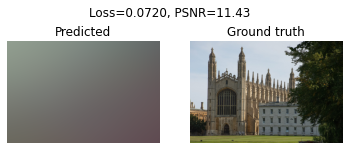

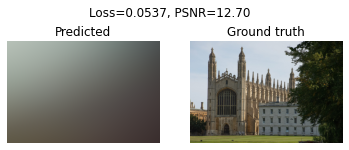

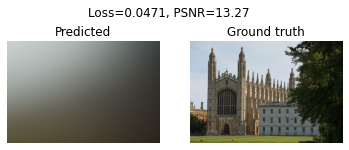

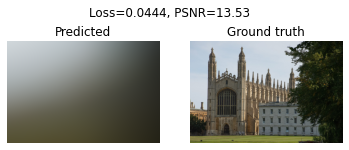

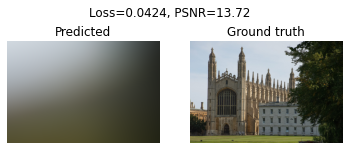

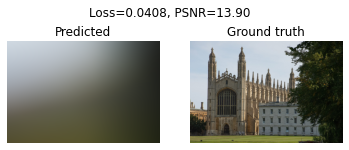

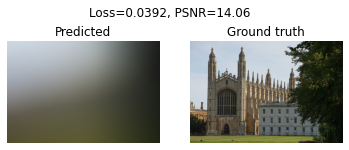

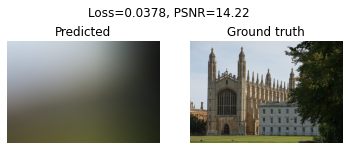

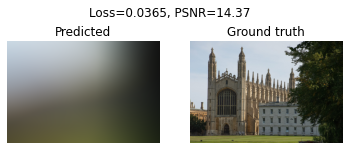

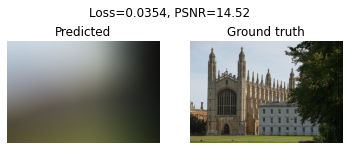

In [6]:
torch.manual_seed(0)

irn = IRN().to(device)

img, coord_grid = img.to(device), coord_grid.to(device)

epochs = 400
lr = 1e-4
opt = torch.optim.Adam(lr=lr, params=irn.parameters())
psnr_fn = torchmetrics.image.PeakSignalNoiseRatio(data_range=1)
psnr_fn.to(device)

pbar = trange(epochs)
for step in pbar:
    opt.zero_grad()
    img_hat = irn(coord_grid)
    loss = ((img - img_hat)**2).mean()
    loss.backward()
    opt.step()
    pbar.set_description(f'Loss={loss.item():0.4f}')

    if (step + 1) % (epochs//10) == 0:
        with torch.no_grad():
            psnr = psnr_fn(img_hat, img)
            fig, ax = plt.subplots(1, 2)
            fig.suptitle(f'Loss={loss.item():0.4f}, PSNR={psnr.item():0.2f}', y=0.8)
            ax[0].imshow(irn(coord_grid).clip(0, 1).cpu().reshape(h, w, 3))
            ax[0].set_title('Predicted')
            ax[0].axis('off')
            ax[1].imshow(img.cpu().reshape(h, w, 3))
            ax[1].set_title('Ground truth')
            ax[1].axis('off')

plt.show()

if device == 'cuda':
    free_memory([irn, opt]) # release memory

If the run completed successfully, you should see a blurry output similar to this:

![Naive result](https://drive.google.com/uc?export=view&id=1xHUdQSOtd7UITz0T37m5oT45qEhB-d-z)

### Task 1
Change the global seed (line 1 in the training code block) to 1 and retrain the network. This results in a significantly poorer reconstruction. Changing the seed results in a different initial configuration of the weights. In fact, most seeds result in poor convergence. Can you identify a network initialization function that results in PSNR > 15 regardless of the seed chosen?

*Constraints:* For this task, you are **not allowed** to change
1. Number of training epochs
2. Network size
3. Optimizer (or its parameters such as learning reta, betas)

**Deliverable:** Quantitative comparison showing the effect of different functions for initialising weights. Use the PSNR metric for all tables and plots.

In [7]:
# reset all model weights. With linear layers, this resets weights uniformly between ±(in_features)^(-1/2) (see: https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)
def reset_model_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# reset parameters using normal distribution
def normal_reset(model, bias=False, type=None):
    match type:
        case None:
            print('Resetting using standard normal...')
        case 'kaiming':
            print('Resetting using Kaiming normal...')
        case 'xavier':
            print('Resetting using Xavier normal...')
        case _:
            raise Exception('Invalid normal initializer type:', type)
    
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            match type:
                case None:
                    nn.init.normal_(layer.weight)
                case 'kaiming':
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                case 'xavier':
                    nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('relu'))

            if bias:
                nn.init.normal_(layer.bias)
            print('reset',layer)

# reset parameters using uniform distribution
def uniform_reset(model, bias=False, type=None, bound=0.1):
    match type:
        case None:
            print('Resetting using standard uniform...')
        case 'kaiming':
            print('Resetting using Kaiming uniform...')
        case 'xavier':
            print('Resetting using Xavier uniform...')
        case _:
            raise Exception('Invalid uniform initializer type:', type)
    
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            match type:
                case None:
                    nn.init.uniform_(layer.weight, -bound, bound)
                case 'kaiming':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                case 'xavier':
                    nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))

            if bias:
                nn.init.uniform_(layer.bias, -bound, bound)
            print('reset',layer)

# reset parameters all to zero
def zeros_reset(model, bias=False):
    print('Resetting to zeros...')
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            nn.init.zeros_(layer.weight)
            if bias:
                nn.init.zeros_(layer.bias)
            print('reset',layer)

# reset parameters all to one
def ones_reset(model, bias=False):
    print('Resetting to ones...')
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            nn.init.ones_(layer.weight)
            if bias:
                nn.init.ones_(layer.bias)
            print('reset',layer)

In [8]:
initializers = {
   reset_model_parameters: [dict()],
    normal_reset: [
        # dict(),
        dict(type='kaiming'),
        dict(type='xavier'),
        # dict(type='xavier', bias=True)
    ],
    uniform_reset: [
        # dict(),
        dict(type='kaiming'),
        dict(type='xavier'),
        # dict(type='xavier', bias=True)
    ],
    # zeros_reset: [dict()],
    # ones_reset: [dict()]
}

Loading from file enabled. Attempting to load pre-saved history.
Loaded initializer result data from file.
Initializer: reset_model_parameters, Parameters: {}


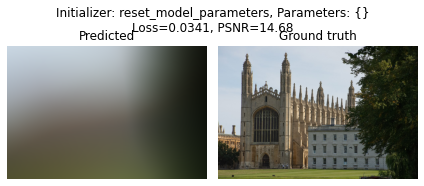

Initializer: normal_reset, Parameters: {'type': 'kaiming'}


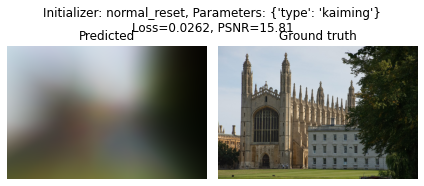

Initializer: normal_reset, Parameters: {'type': 'xavier'}


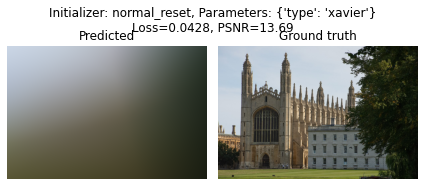

Initializer: uniform_reset, Parameters: {'type': 'kaiming'}


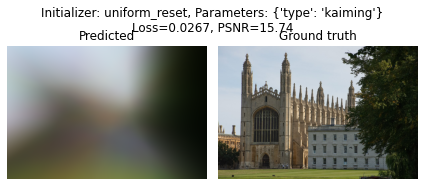

Initializer: uniform_reset, Parameters: {'type': 'xavier'}


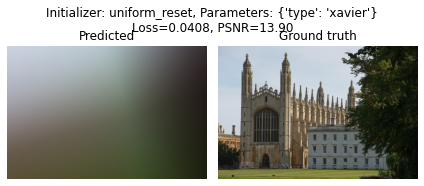

In [9]:
irn = IRN().to(device)

img, coord_grid = img.to(device), coord_grid.to(device)

epochs = 400
lr = 1e-4
psnr_fn = torchmetrics.image.PeakSignalNoiseRatio(data_range=1).to(device)
opt = torch.optim.Adam(lr=lr, params=irn.parameters())

load_from_file = True

init_results = {}

load_successful = False
if load_from_file:
    print('Loading from file enabled. Attempting to load pre-saved history.')
    try:
        init_results = dill.load(open(f'initializers_history.pkl', 'rb'))
        load_successful = True
        print(f'Loaded initializer result data from file.')
        for init_fn_name, init_params_results in init_results.items():
            for init_kwargs, (_, fig) in init_params_results.items():
                print(f'Initializer: {init_fn_name}, Parameters: {init_kwargs}')
                display(fig)
    except FileNotFoundError:
        print(f'Initializer result data not found. Training models...')
else:
    print('Load from file disabled. Training models...')

if not load_successful:            
    for init_fn, init_params in initializers.items():
        init_results[init_fn.__name__] = {}
        
        for init_kwargs in init_params:
            print(f'Initializer: {init_fn.__name__}, Parameters: {init_kwargs}')
            
            torch.seed()
            init_fn(irn, **init_kwargs)

            history = {
                'loss': [],
                'psnr': []
            }

            pbar = trange(epochs)
            for epoch in pbar:
                opt.zero_grad()

                img_hat = irn(coord_grid)

                loss = ((img - img_hat)**2).mean()
                loss.backward()

                opt.step()

                pbar.set_description(f'Loss={loss.item():0.4f}')
                history['loss'].append(loss.item())
                history['psnr'].append(psnr_fn(img_hat, img).item())

            with torch.no_grad():
                psnr = psnr_fn(img_hat, img)
                fig, ax = plt.subplots(1, 2)
                fig.suptitle(f'Initializer: {init_fn.__name__}, Parameters: {init_kwargs}\nLoss={loss.item():0.4f}, PSNR={psnr.item():0.2f}', y=0.8)
                ax[0].imshow(irn(coord_grid).clip(0, 1).cpu().reshape(h, w, 3))
                ax[0].set_title('Predicted')
                ax[0].axis('off')
                ax[1].imshow(img.cpu().reshape(h, w, 3))
                ax[1].set_title('Ground truth')
                ax[1].axis('off')

                plt.tight_layout()

                init_results[init_fn.__name__][str(init_kwargs)] = (history, fig)

                plt.show()

    dill.dump(init_results, open(f'initializers_history.pkl', 'wb'))

if device == 'cuda':
    free_memory([irn, opt]) # release memory

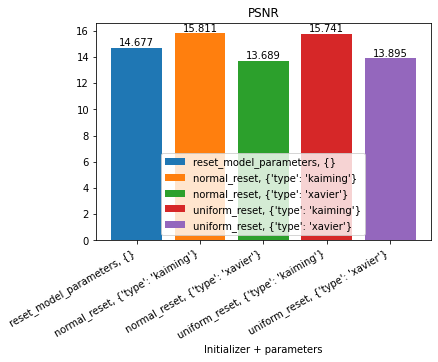

In [10]:
x = 0
bars = []
labels = []
for init_fn_name, init_params_results in init_results.items():
    for init_kwargs, (results, fig) in init_params_results.items():
        labels.append(f'{init_fn_name}, {init_kwargs}')
        bar = plt.bar(x, results['psnr'][-1], label=labels[-1])
        plt.bar_label(bar, fmt='{:.3f}')
        x += 1

plt.title('PSNR')
plt.xticks(np.arange(x), labels, rotation=30, ha='right', va='top')
plt.xlabel('Initializer + parameters')
plt.legend(loc='lower center')

plt.show()

Based on my experimentation, I found that using Kaiming initialization with either the normal or uniform distributions results in improved performance over the default initialization (PSNR of 15.811 and 15.741 respectively compared to 14.677 on the default initialization technique). I also tried Xavier initialization, however I was unable to get this to produce consistent results, often underperforming the default. Notably, looking at the source code for the default `reset_parameters` function, the default initialization technique actually uses Kaiming uniform. However, it does not set the activation technique, causing it to default to LeakyReLU instead of standard ReLU (what we are using).

I will also note that in order to get consistent results, I had to change the final activation function of the model from ReLU to sigmoid. This felt necessary, as the expected of the model is supposed to be bounded within the `[0,1]` range anyways. This results in slightly different behavior from the code as initially provided, but was necessary to prevent cases where the weights or biases get too large and cause the output to clip. Thus the use of sigmoid improved the stability significantly (though did not noticeably improve performance compared to ReLU on the default initialization with set seed 0).

### Task 2
Experiment with different architectures (deeper or wider networks), different reconstruction losses (L1, Huber) and optimizers. Report your results, again with quantitative metrics. Check if your design choices are consistent for different inputs with possibly different resolutions.

You will notice that the network is unable to fit the image properly because it is limited by the number of input dimensions. You can fix this by *Fourier feature mapping* — by passing the input 2D coordinates through a Positional Encoding function [1] — to better learn high-frequencies in the image.

[1] Tancik, Matthew, et al. "Fourier features let networks learn high frequency functions in low dimensional domains." Advances in Neural Information Processing Systems 33 (2020): 7537-7547. Link: https://proceedings.neurips.cc/paper/2020/hash/55053683268957697aa39fba6f231c68-Abstract.html

Specifically, you will implement the Gaussian Fourier feature mapping: $\gamma(\mathbf{g})= \left[ \cos(2 \pi \mathbf B \mathbf{g}), \sin(2 \pi \mathbf B \mathbf{g}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times 2}$ is sampled from $\mathcal N(0,\sigma^2)$. Here, $m$ is the number of normally distributed sinosoidal frequencies and $\mathbf g = (x, y)$ is an input 2D coordinate.

The Fourier feature mapping $\gamma(\mathbf g)$ thus provides a $2 \times m$ input to the MLP. In place of the direct mapping, we learn
$$(r, g, b) = f(\gamma(\mathbf g)).$$

**Deliverable:** Demonstrate the effectiveness of FFN on own your set of diverse images. Different images will benefit from a different choice of $\sigma$ (standard deviation of frequencies). Show the result of fitting an INR with FFN for an image composed of lower frequencies (such as sky) as well as an image with high frequencies (such as grass).

file: grass.jpg std: 1
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0105: 100%|██████████| 400/400 [00:48<00:00,  8.29it/s]


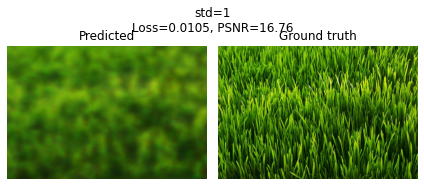

file: grass.jpg std: 5
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0078: 100%|██████████| 400/400 [00:48<00:00,  8.23it/s]


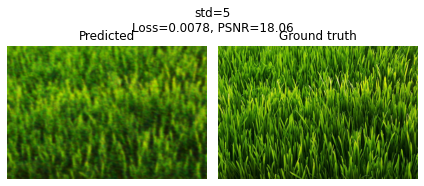

file: grass.jpg std: 10
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0093: 100%|██████████| 400/400 [00:48<00:00,  8.29it/s]


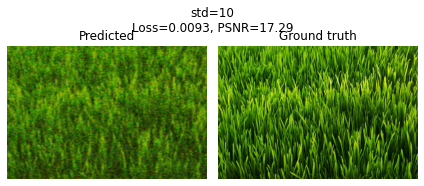

file: sky.jpg std: 1
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0020: 100%|██████████| 400/400 [01:25<00:00,  4.69it/s]


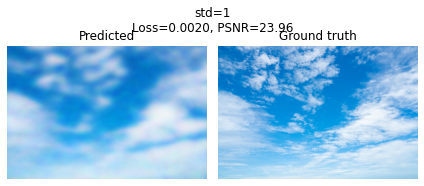

file: sky.jpg std: 5
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0016: 100%|██████████| 400/400 [01:25<00:00,  4.70it/s]


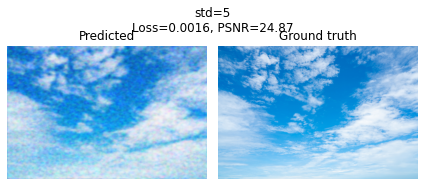

file: sky.jpg std: 10
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0040: 100%|██████████| 400/400 [01:25<00:00,  4.69it/s]


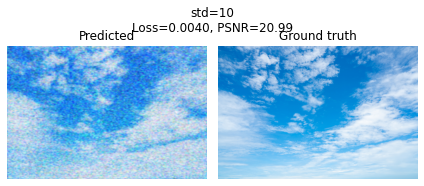

file: kings_chapel.jpg std: 1
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0076: 100%|██████████| 400/400 [01:25<00:00,  4.69it/s]


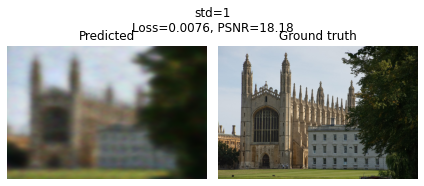

file: kings_chapel.jpg std: 5
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0053: 100%|██████████| 400/400 [01:25<00:00,  4.69it/s]


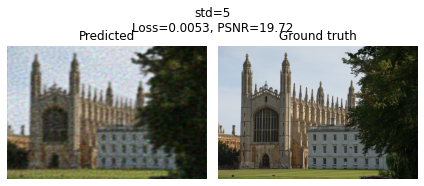

file: kings_chapel.jpg std: 10
Resetting using Kaiming normal...
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=256, bias=True)
reset Linear(in_features=256, out_features=3, bias=True)


Loss=0.0080: 100%|██████████| 400/400 [01:25<00:00,  4.68it/s]


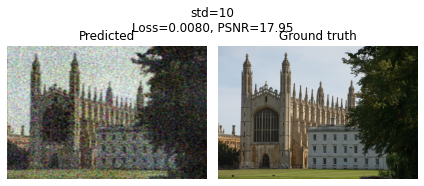

In [25]:
images = ['grass.jpg', 'sky.jpg', 'kings_chapel.jpg']
stds = [1, 5, 10]

epochs = 400
lr = 1e-4
psnr_fn = torchmetrics.image.PeakSignalNoiseRatio(data_range=1).to(device)
loss_fn = nn.HuberLoss()

for filename, std in itertools.product(images, stds):
    print(f'file: {filename} std: {std}')

    irn = IRN(positional_encoding=True, std=std).to(device)
    opt = torch.optim.Adam(lr=lr, params=irn.parameters())
    
    img = torchvision.io.read_image(filename) / 255
    _, h, w = img.shape
    img = img.permute(1,2,0).reshape(-1, 3).to(device)

    tensors = (torch.linspace(-1, 1, steps=h), torch.linspace(-1, 1, steps=w))
    coord_grid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1).reshape(-1, 2).to(device)

    normal_reset(irn, type='kaiming')
    
    pbar = trange(epochs)
    for step in pbar:
        opt.zero_grad()
        
        img_hat = irn(coord_grid)
        
        loss = loss_fn(img_hat, img)
        loss.backward()
        
        opt.step()
        
        pbar.set_description(f'Loss={loss.item():0.4f}')
    
    with torch.no_grad():
        psnr = psnr_fn(img_hat, img)
        fig, ax = plt.subplots(1, 2)
        fig.suptitle(f'std={std}\nLoss={loss.item():0.4f}, PSNR={psnr.item():0.2f}', y=0.8)
        ax[0].imshow(irn(coord_grid).clip(0, 1).cpu().reshape(h, w, 3))
        ax[0].set_title('Predicted')
        ax[0].axis('off')
        ax[1].imshow(img.cpu().reshape(h, w, 3))
        ax[1].set_title('Ground truth')
        ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if device == 'cuda':
        free_memory([irn, opt]) # release memory

### Task 3
The neural network approximates a continuous signal and can be queried at arbitrary resolutions. Your final task is to produce a 4x upsampled image by providing a denser input grid to the network. Recall that the grid coordinates are rescaled to the range $[0,1]$.